In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime
import glob

import os
# import cPickle as pickle

import seaborn as sns
sns.set_style("whitegrid")

def generate_default_plot_env():
    sns.set(font_scale=1.4, style="whitegrid")
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rc('font', serif='Helvetica Neue') 
    matplotlib.rc('text', usetex='false') 
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rc('font', family='sans-serif') 
    plt.rc('font', serif='Helvetica Neue') 
    plt.rc('text', usetex='false') 
    plt.rcParams.update({'font.size': 22})

generate_default_plot_env()

In [3]:
more_diff_plot_df = pd.read_csv("../data/minutes_inset.csv")

In [16]:
scale = 3.25
c_fsize = 10
a_fsize = 10
def plot_pre_post_freqs(diff_plot_df, bin_size=10, min_steps_per_min=10, 
                        ylim=(-scale, scale), day_group=7, ax=None, 
                        axis_fontsize=a_fsize, category_fontsize=c_fsize, axis_every=3):
    x_axis = 'steps_per_min_bin'
    diff_plot_df['steps_per_min_bin'] = pd.cut(diff_plot_df['steps_per_min'], right=False, bins=[el for idx, el in enumerate(more_diff_plot_df["steps_per_min"]) if (idx % bin_size) == 0], include_lowest=True)
    diff_plot_df = diff_plot_df.groupby(by='steps_per_min_bin').sum().reset_index()
    
    def convert_properly(value):
        return (value - min_steps_per_min) / bin_size
    
    if ax is None:
        f, ax = plt.subplots(figsize=(20,10))
        
    def no_bracket_left(string):
        if not isinstance(string,str):
            string = str(string)
        if '[' in string: 
            string = string.replace('[', '')
        if ']' in string: 
            string = string.replace(']', '')
        if '(' in string: 
            string = string.replace('(', '')
        if ')' in string: 
            string = string.replace(')', '')
        
        return string.split(',')[0]
    
    centerline_color = '#590059'
    colors = ['grey' if int(no_bracket_left(_x)) < 100 else centerline_color for _x in diff_plot_df['steps_per_min_bin']]
    sns.barplot(x=x_axis, y='difference', data=diff_plot_df, palette=colors, ax=ax)
    ax.axhline(y=0, color='grey', linewidth=1.0)
    ax.axvline(x=convert_properly(100), linestyle="--", color='k', linewidth=1)
    
    from matplotlib.transforms import blended_transform_factory
    tform = blended_transform_factory(ax.transData, ax.transAxes)
        
    ax.grid(False)
    a = [no_bracket_left(val.get_text()) for val in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticklabels(a)
    
    for idx, label in enumerate(ax.xaxis.get_ticklabels()):
        if idx % axis_every != 0:
            label.set_visible(False)
    
    ax.set_xlabel('$I$ (Steps / Minute)')
    ax.set_ylabel('$\Delta T(I)$')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(axis_fontsize)
    
    if ylim is not None:
        ax.set_ylim(bottom=day_group*ylim[0], top=day_group*ylim[1]);

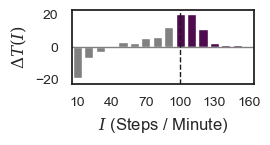

In [17]:
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig, ax = plt.subplots(figsize=(2.5, 1.25))
plot_pre_post_freqs(more_diff_plot_df, ax=ax)
ax.yaxis.label.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)
plt.setp(ax.spines.values(), color='k')
fig.tight_layout(pad=0);
fig.savefig('../output/minutes_inset/mins_added_48_80.png', dpi=600)

In [18]:
movers_minutes_df = pd.read_csv("../data/mins_diff_vs_ws_diff.csv")
more_specific_df = pd.read_csv("../data/mins_diff_vs_ws_diff_detailed.csv")

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

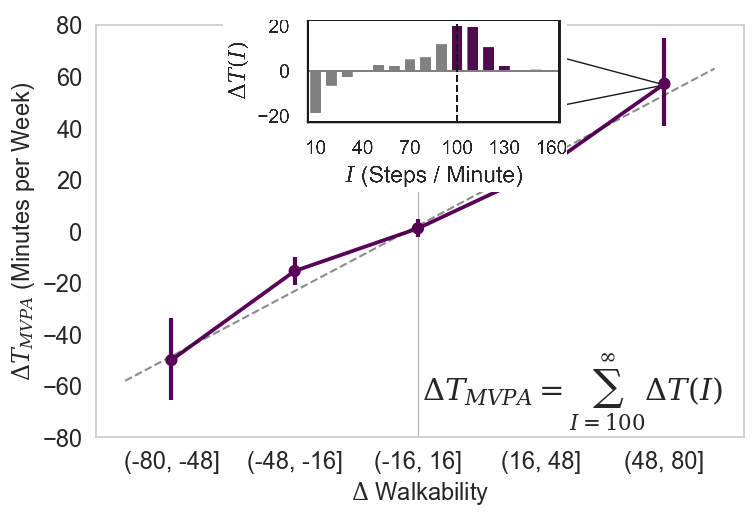

In [22]:
width = 8
height = 0.7*width
fig, ax = plt.subplots(figsize=(width, height))
centerline_color = '#590059'
sns.pointplot(y='mean', x='delta_WS_bin', data=movers_minutes_df, ax=ax, color=centerline_color)
ax.errorbar(x=[0, 1, 2, 3, 4], y=movers_minutes_df['mean'], 
            yerr=[movers_minutes_df['bottom_ci'], movers_minutes_df['top_ci']], 
            linestyle="None", ecolor=centerline_color,
            elinewidth=3.0, label=None)

ax.axvline(x=2, color='#b0b0b0', linewidth=0.8, zorder=-1)

more_specific_df_new = pd.DataFrame([more_specific_df.loc[idx] 
                                     for idx in more_specific_df.index 
                                     for _ in range(more_specific_df.loc[idx]['n_moves'])]).reset_index(drop=True)

p = sns.regplot(x=2.5 + (more_specific_df_new['delta_WS'] - 16)/32, y=more_specific_df_new['delta_mins'], 
            x_bins=range(-2, 2+1, 1), scatter=False, ax=ax, ci=None, color='k', 
            line_kws={'linestyle': '--', 'linewidth': 1.5, 'color':'k', 'alpha': 0.5})

ax.set_ylabel('$\Delta T_{MVPA}$ (Minutes per Week)');
ax.set_xlabel('$\Delta$ Walkability');
ax.set_ylim((-80, 80))
ax.grid(False)

inset_fig = plt.imread('../output/minutes_inset/mins_added_48_80.png', format='png');

imagebox = OffsetImage(inset_fig, zoom=0.165)
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, (4, more_diff_plot_df.loc[more_diff_plot_df['steps_per_min'] >= 100, 'difference'].sum()),
                    xybox=(-270, -21),
                    xycoords='data',
                    boxcoords="offset pixels",
                    bboxprops={'fc': 'white'},
                    frameon=False,
                    pad=0.5)
ax.add_artist(ab)

color = 'k'
ax.annotate('',
            xy=(4, more_diff_plot_df.loc[more_diff_plot_df['steps_per_min'] >= 100, 'difference'].sum()), 
            xycoords='data',
            xytext=(-150, 40), 
            textcoords='offset pixels',
            size=15,
            arrowprops=dict(arrowstyle="-", 
                            color=color,
                            lw=1.,
                            shrinkA=0, shrinkB=0),
            color=color, zorder=0)
ax.annotate('',
            xy=(4, more_diff_plot_df.loc[more_diff_plot_df['steps_per_min'] >= 100, 'difference'].sum()), 
            xycoords='data',
            xytext=(-150, -30), 
            textcoords='offset pixels',
            size=15,
            arrowprops=dict(arrowstyle="-", 
                            color=color,
                            lw=1.,
                            shrinkA=0, shrinkB=0),
            color=color, zorder=0)

ax.text(3.25, -78,
        '$\Delta T_{MVPA} = \sum_{I=100}^{\infty} \Delta T(I)$', 
        ha='center', va='bottom', fontsize=22)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(17)

plt.tight_layout();
plt.savefig("../output/fig3d.pdf", dpi=300)